In [87]:
###抓SQL資料
#################連結SQL
import pandas as pd
import pyodbc
#import eikon as ek  # the Eikon Python wrapper package
import numpy as np # NumPy
#import cufflinks as cf  # Cufflinks
import configparser as cp
#API 存成 pd.dataframe
import math
from datetime import datetime
import matplotlib.pyplot as plt

server = 'W82700152\sqlexpress' 
database = 'Fund' 
username = 'CTBC_Research' 
password = 'Research!!' 
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
query = "SELECT [Date],[Ticker],[Value],[flag],[flag_tier2] FROM [Fund].[dbo].[Warning_D_2]"       
dic_df= pd.read_sql(query, cnxn)
dic_df
#存檔d
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/flag.xlsx')
dic_df.to_excel(writer,'工作表1')
writer.save()

In [88]:

##所有基本function

########################################################################拿取price資料
def get_price(subject='美國'):
    '''取得price data'''
    import pandas as pd
    import numpy as np
    import tqdm
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use("ggplot")
    
    #參數設定
    #observe_period = 60
    #predict_period = 60
    #predict_cycle=1
    
    
    df=pd.read_excel('ETF_price.xlsx', sheet_name ='price',encoding='big5')
    df['Date']=pd.to_datetime(df['Date'])
    df=df.set_index(keys=['Date'])
    df.sort_values("Date",inplace=True)    
    #轉成set
    column_name=set(df.columns)  
    #保留資料長度>2400的
    #for name in column_name:
    #    if df[name].count()<2400:
    #        df=df.drop(columns=[name])
    
     
    #製作(國家~~ISIN) dictionary
    country_dic={ '中國A':'SHCOMP Index',
                  '東協':'MXSO Index',        
                  '美國':'SPX Index',
                  '泛太平洋':'MXAP Index',
                  '拉丁美洲':'MXLA Index',
                  '新興亞洲':'MXMS Index',
                  '新興歐洲':'MXMU Index',
                  '歐洲':'SX5P Index',
                 }                

              
    df_price=df[country_dic[subject]].dropna()
   
    #補上 predict_period 個假資料 (for 預測
    #dti=pd.date_range(price.index[-1]+pd.Timedelta(days=1),freq='D',periods=predict_period)
    #temp=pd.Series(index=dti)
    #price=pd.concat([price,temp])
    
   
    indexes = df_price.index    
    #Split traning and testing data
    #import datetime
    #price_train = price[indexes < datetime.datetime(2012,1,1)]
    #price_test = price[indexes >= datetime.datetime(2012,1,1)]    
    
    
    return (df_price,indexes)

########################################################################拿取features資料_flag
def get_features_flag():
    '''取得所有flag'''
    import pandas as pd
    import numpy as np
    import tqdm
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use("ggplot")
    
    df_features_SQL=pd.read_excel('flag.xlsx', sheet_name ='工作表1',encoding='big5')
    df_features_SQL['Date']=pd.to_datetime(df_features_SQL['Date'])
    df_features_SQL=df_features_SQL.set_index(keys=['Date'])
    df_features_SQL.sort_values("Date",inplace=True)    

    facet=list(df_features_SQL['flag'].unique())   #5大構面
    
    
    return df_features_SQL

########################################################################拿取features資料_oracle
def get_features_oracle():
    '''取得所有flag'''
    import pandas as pd
    import numpy as np
    import tqdm
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use("ggplot")
    
    df_features_oracle=pd.read_excel('oracle.xlsx', sheet_name ='工作表1',encoding='big5')
    df_features_oracle['Date']=pd.to_datetime(df_features_oracle['Date'])
    df_features_oracle=df_features_oracle.set_index(keys=['Date'])
    df_features_oracle.sort_values("Date",inplace=True)    

    facet=list(df_features_oracle.columns.unique())   #

    
    return df_features_oracle

########################################################################合併原始features檔案
'''
def get_features_all(features_SQL,features_oracle):
    
    import pandas as pd
    import numpy as np
    import tqdm
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use("ggplot")
    
    df_features=features_SQL.append(features_oracle)


    features_name=list(df.columns.unique())   #
    
    return (df_features,features_name)
'''    
########################################################################製作features & label 表
def create_features(df_price,df_features_SQL,shift):
    '''製作所有features'''
    import talib
    import numpy as np
    import pandas as pd

    #ticker_list=list(df_features_SQL['Ticker'].unique())

  
    ticker_list=['EURJPYV3M BGN Curncy',
                 'MOVE Index',
                 'EURTWD CMPN Curncy',
                 'JPMVXYGL Index',
                 'IGOV-G0BC',
                 'XAU Curncy',
                 'MSCI EMU INDEX_ERR',
                 'EU5Y-2Y',
                 'MXN CMPN Curncy',
                 'MSCI GERMANY INDEX_ERR',
                 'MSCI AC ASIA PAC EX JAPN INDEX_ERR',
                 'HW00-GOBC',
                 'NKY_MXWO',
                 'ER00-C0A0',
                 'MSCI TAIWAN INDEX_ERR',
                 'IGOV-C0A0',
                 'GSEAFCI Index',
                 'V2X Index',
                 'EURUSDV3M BGN Curncy',
                 'MXEF0CX0 Index',
                 'M0A0',
                 'MXLA_MXEF',
                 'G0BC-GBMI',
                 'GBP CMPN Curncy',
                 'SXXP_MXWO',
                 'EUR CMPN Curncy',
                 'JPMVXYG7 Index',
                 'US5-US2',
                 'MSCI EM INDEX_ERR',
                 'MXMU_MXEF',
                 'INR CMPN Curncy',
                 'JPY_EUR',
                 'JPY_USD',
                 'IDR CMPN Curncy',
                 'GSUSFCI Index',
                 'MSCI EM LATIN AMERICA INDEX_ERR',
                 'MXWO-MXEF',
                 'SPX_MXWO',
                 'MSCI JAPAN INDEX_ERR',
                 'SP500 INDEX_ERR',
                 'USDTWD CMPN Curncy',
                 'ZAR CMPN Curncy',
                 'MXMS_MXEF',
                 'MSCI EM Eur ME  Africa INDEX_ERR',
                 'US30-US10',
                 'JPMVXYEM Index',
                 'RUB CMPN Curncy',
                 'US10-US5',
                 'HE00-H0A0',
                 'DXY Curncy',
                 'VIX Index',
                 'HW00-C0A0',
                 'US2-US3m',
                 'R0A0',
                 'GSJPFCI Index',
                 'EUBOR-OIS',
                 'MSCI WORLD INDEX_ERR',
                 'MSCI UK INDEX_ERR',
                 'BRL CMPN Curncy',
                 'CRY Index',
                 'MSCI CHINA INDEX_ERR',
                 'H0A0-C0A0',
                 'FXJPEMCI Index',
                 'HE00-ER00',
                 'JP30Y-10Y',
                 'EU10Y-5Y',
                 'CMXOGNCN Index',
                 'JP10Y-5Y',
                 'EU30Y-10Y',
                 'EUTED-spread',
                 'JP5Y-2Y',
                 'CL1 Comdty',
                 'EU10Y-3m',
                 'TED-spread',
                 'BDIY Index',
                 'CO1 Comdty',
                 'EU2Y-3m',
                 'JPYTWD CMPN Curncy',
                 'INJCJC4 Index',
                 'EU_GOVT_LIQUIDITY',
                 'GERMAN_LOIS',
                 'CNPPIY Index',
                 'CONSSENT Index',
                 'NAPMPMI Index',
                 'JPEIGLSP Index',
                 'CNMS1YOY Index',
                 'CSIIEUR Index',
                 'CEWSEM Index',
                 'JIPSDURA Index',
                 'CONCEXP Index',
                 'EPUCCUSM Index',
                 'JWEXBUS Index',
                 'NAPMEMPL Index',
                 'CSIIEM Index',
                 'KOEXTOTY Index',
                 'GRZEEUCU Index',
                 'EPUCCEUM Index',
                 'CSIIUSD Index',
                 'JNMTOY Index',
                 'EUR3EU27 Index',
                 'CSIIAPAC Index',
                 'EUCCEMU Index',
                 'VNKY Index',
                 'LIBOR-OIS',
                 'CESIEM Index',
                 'CESIEUR Index',
                 'CESIUSD Index',
                 'CESIAPAC Index',
                 'CESIBRIC Index',
                 'TIPS-US5Y',
                 'TYVIX Index',
                 'BSEKOAS Index',
                 'EMHG-IGOV',
                 'EMHY-EMHG',
                 'JCOMACF Index',
                 'ITRX JAPAN CDSI GEN 5Y Corp',
                 'CNNMHTMY Index',
                 'GVLQDE Index',
                 'GVLQUSD Index',
                 'GVLQJPY Index',
                 'JYVIX Index',
                 'EUVIX Index',
                 'NBBDBAT Index',
                 'TFEOPCR Index',
                 'CNH CMPN Curncy',
                 'CDX IG CDSI GEN 5Y Corp',
                 'ITRX EUR CDSI GEN 5Y Corp']
    
    #做出dataframe
    dataset = pd.DataFrame({
    'return': df_price.shift(-40)/df_price > 1,   #N天後的報酬率, 是否>1  --->label
        
    })
    #逐一將feature插入dataframe
    for ticker in ticker_list:
        feature=df_features_SQL[df_features_SQL['Ticker']==ticker]['Value']
        dataset[ticker]=feature

    #結合oracle抓的features    
    #dataset=dataset.append(df_features_oracle)

    
    column_name=set(dataset.columns)  #轉成set
    column_name.remove('return')
    #30個月(max-min)化  
    #for variable in column_name: 
    #    dataset[variable]=(dataset[variable]-dataset[variable].rolling(625).min())/(dataset[variable].rolling(625).max()-dataset[variable].rolling(625).min()
    
    #diff化  
    #for variable in column_name: 
    #    dataset[variable]=(dataset[variable]-dataset[variable].shift(20))+(dataset[variable].shift(20)-dataset[variable].shift(40))+(dataset[variable].shift(40)-dataset[variable].shift(60))
    
    #取平均化  
    #for variable in column_name: 
    #    dataset[variable]=dataset[variable].rolling(20).mean()   
    
    
    #z-score化  
    for variable in column_name: 
        dataset[variable]=(dataset[variable]-dataset[variable].rolling(40).mean())/dataset[variable].rolling(40).std()
    
    #diff化  
    #for variable in column_name: 
    #    dataset[variable]=(dataset[variable]-dataset[variable].shift(20))/dataset[variable].rolling(20).std()   


    #計算技術指標
    sma = talib.SMA(df_price, timeperiod=6)
    wma = talib.WMA(df_price, timeperiod=6)
    mom = talib.MOM(df_price, timeperiod=6)
    k, d = talib.STOCH  (df_price, df_price, df_price, fastk_period=5, slowk_period=1, slowd_period=1)
    k2, d2 = talib.STOCH(df_price, df_price, df_price, fastk_period=10, slowk_period=10, slowd_period=1)
    k3, d3 = talib.STOCH(df_price, df_price, df_price, fastk_period=20, slowk_period=20, slowd_period=1)
    k4, d4 = talib.STOCH(df_price, df_price, df_price, fastk_period=40, slowk_period=40, slowd_period=1)
    k5, d5 = talib.STOCH(df_price, df_price, df_price, fastk_period=60, slowk_period=60, slowd_period=1)
    k6, d6 = talib.STOCH(df_price, df_price, df_price, fastk_period=120, slowk_period=120, slowd_period=1)
    k7, d7 = talib.STOCH(df_price, df_price, df_price, fastk_period=240, slowk_period=120, slowd_period=1) 
    rsi = talib.RSI (df_price, timeperiod=5)
    rsi2 = talib.RSI(df_price, timeperiod=10)
    rsi3 = talib.RSI(df_price, timeperiod=20)
    rsi4 = talib.RSI(df_price, timeperiod=40)
    rsi5 = talib.RSI(df_price, timeperiod=60)
    rsi6 = talib.RSI(df_price, timeperiod=120)
    rsi7 = talib.RSI(df_price, timeperiod=240)    
    macd1, macd2, macd3 = talib.MACD(df_price, fastperiod=6, slowperiod=3, signalperiod=3)
    willr = talib.WILLR(df_price, df_price, df_price, timeperiod=6)
    cci = talib.CCI(df_price, df_price, df_price, timeperiod=6)
    
    #技術指標
    technical = pd.DataFrame({
    'RSIb': rsi ,
    'RSIb2': rsi2 ,
    'RSIb3': rsi3 ,
    'RSIb4': rsi4 ,
    'RSIb5': rsi5 ,
    'RSIb6': rsi6 ,
    'RSIb7': rsi7 ,    
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    
    'a5':   (df_price.rolling(5).mean()   / df_price),
    'a10':  (df_price.rolling(10).mean()  / df_price),
    'a20':  (df_price.rolling(20).mean()  / df_price),
    'a40':  (df_price.rolling(40).mean()  / df_price),
    'a80':  (df_price.rolling(80).mean()  / df_price),
    'a160': (df_price.rolling(160).mean() / df_price),
    'a320': (df_price.rolling(320).mean() / df_price),

    'b1': df_price/df_price.shift(5),
    'b2': df_price/df_price.shift(10),
    'b3': df_price/df_price.shift(20),
    'b4': df_price/df_price.shift(40),
    'b5': df_price/df_price.shift(60),
    'b6': df_price/df_price.shift(120),
    'b7': df_price/df_price.shift(240),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(df_price, 5),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(df_price, 10),

    'ADXR0': talib.ADXR(df_price, df_price, df_price, 5),
    'ADXR1': talib.ADXR(df_price, df_price, df_price, 10),
    'ADXR2': talib.ADXR(df_price, df_price, df_price, 20),
    'ADXR3': talib.ADXR(df_price, df_price, df_price, 40),
    'ADXR4': talib.ADXR(df_price, df_price, df_price, 60),
    'ADXR5': talib.ADXR(df_price, df_price, df_price, 120),    

    })
    
    dataset_new = dataset.join(technical)
    #dataset_new = dataset.dropna(how='any',axis=1) 
    
    feature_names = list(dataset_new.columns[:-1])
    feature_names.remove('return')              #移除return, 否則train過程偷看答案
    #dataset_new = dataset_new.dropna(how='any',axis=1) 
    

    return (dataset_new ,feature_names)



In [95]:
########################################################################訓練+回測 lightgbm  (分3個平行世界投票) (train+predict分開)

def multiple_choose_rank_model(period_rolling=3):
    '''分5個平行世界投票'''
    import pandas as pd
    import numpy as np
    import lightgbm as lgb
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    country_dic={'中國A':'SHCOMP Index',
                 '東協':'MXSO Index',
                 '美國':'SPX Index',
                 '泛太平洋':'MXAP Index',
                 '拉丁美洲':'MXLA Index',
                 '新興亞洲':'MXMS Index',
                 '新興歐洲':'MXMU Index',
                 '歐洲':'SX5P Index',
                    }
    
    #創建空白dataframe
    df_outcome=pd.DataFrame(columns=[n for n in country_dic.keys()])
    df_proba=pd.DataFrame(columns=[n for n in country_dic.keys()])
    
    #參數:
    priority_number=50  #取前n個importance的feature
    predict_period=40  #預測天數  
    
    
    #train period (固定)    
    period=[x  for x in range(2007,2017,1)]
    save=[None]*20
    for x in range(0,len(period)-period_rolling,period_rolling):
        save[x]=[period[x],period[x+period_rolling-1],period[x+period_rolling-1]]
    save2 = list(filter(None, save)) 
    
    


    #model dict
    model_dic={}   
    for x in country_dic.keys():
        model_dic[x]=[None]*len(save2)          
        
    ###第1次train:建構平行世界,存取model
    for x in save2:
        date_startbacktest=str(x[0])
        date_endbacktest=str(x[1])
        date_test=str(x[2])
        print(date_startbacktest,date_endbacktest,date_test)
        train_start=date_startbacktest
        train_end=date_endbacktest
        test_start=date_test
        test_end=date_test
        
        
        
        df_features_SQL=get_features_flag()
        #df_features_SQL=df_features_SQL['2006/1/2':'2020/12/25']
        #df_features_SQL=df_features_SQL.dropna(how='any',axis=1) 

        for country in country_dic.keys():
            print('開始訓練'+country)
       
            gbm = lgb.LGBMClassifier(n_estimators=1000, random_state=5, learning_rate=0.05)
            (df_price,indexes)=get_price(subject=country)
            (dataset,feature_names)=create_features(df_price=df_price,df_features_SQL=df_features_SQL,shift=predict_period)    
                                 
            
            dataset_train = dataset.loc[train_start:train_end]
            dataset_test = dataset.loc[test_start:test_end]
            
            train = dataset_train[feature_names], dataset_train['return']
            test = dataset_test[feature_names], dataset_test['return']
            
            gbm.fit(*train)
            model_dic[country][save2.index(x)]=gbm
            


            
######################################################
    #test period  
    period_test=pd.period_range('1/1/2016','1/4/2021',freq='M')
    #選中的model dict
    model_choose_dic={}   
    for x in country_dic.keys():
        model_choose_dic[x]=None
        

    
    print('     ')
    print('##########開始選model並test data:')
    ###開始樣本外choose  &  test
    count=0 
    for i in range(14,len(period_test),1):

        print("測試區間{0}  {1}".format(period_test[i].start_time,period_test[i].end_time))

        test_start=period_test[i].start_time
        test_end=period_test[i].end_time        
        
        df_features_SQL=get_features_flag()
        #df_features_SQL=df_features_SQL['2006':'2020/12/25']
        #df_features_SQL=df_features_SQL.dropna(how='any',axis=1) 
      

        for country in country_dic.keys():
            

            
            score_list=[-100]
            for model in model_dic[country]:
                gbm = model     #挑出其中一個model
                (df_price,indexes)=get_price(subject=country)
                (dataset,feature_names)=create_features(df_price=df_price,df_features_SQL=df_features_SQL,shift=predict_period)    
                
                #過去1個月回測score
                test_start=period_test[i-3].start_time
                test_end=period_test[i-3].end_time
                
                dataset_test = dataset.loc[test_start:test_end]
                test = dataset_test[feature_names], dataset_test['return']                
                score1=gbm.score(*test)
                
                
                #過去3個月回測score
                test_start=period_test[i-5].start_time
                test_end=period_test[i-3].end_time
                
                dataset_test = dataset.loc[test_start:test_end]
                test = dataset_test[feature_names], dataset_test['return']                
                score2=gbm.score(*test)                
                
                
                #過去6個月回測score
                test_start=period_test[i-8].start_time
                test_end=period_test[i-3].end_time
                
                dataset_test = dataset.loc[test_start:test_end]
                test = dataset_test[feature_names], dataset_test['return']                
                score3=gbm.score(*test)                  
                
                
                #過去12個月回測score
                test_start=period_test[i-14].start_time
                test_end=period_test[i-3].end_time
                
                dataset_test = dataset.loc[test_start:test_end]
                test = dataset_test[feature_names], dataset_test['return']                
                score4=gbm.score(*test)                   
                
                
                
                score_sum=score2+score3+score4
                
            
                if score_sum>=max(score_list):
                    model_choose_dic[country]=gbm
     
                score_list.append(score_sum)
            
            
            #用選出的model預測t的data
            gbm = model_choose_dic[country]
            #gbm = model_dic[country][0]   #檢查測試用code
            test_start=period_test[i].start_time
            test_end=period_test[i].end_time
  
                
            dataset_test = dataset.loc[test_start:test_end] 
            test = dataset_test[feature_names], dataset_test['return']
            print("{0}的score為 {1}".format(country,gbm.score(*test)))
            
            #存成dataframe~score
            df_outcome.loc[count,country]=round(gbm.score(*test),4)
            df_outcome.loc[count,'date']=test_start
            
            #存成dataframe~proba     
            df_proba.loc[count,country]=gbm.predict_proba(dataset_test[feature_names])[-1][1]
            df_proba.loc[count,'date']=test_start            
    
        count=count+1
    
    #存檔
    writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3).xlsx')
    df_outcome.to_excel(writer,'outcome')
    df_proba.to_excel(writer,'proba')
    writer.save()
    return (df_outcome,dataset,model_dic)


In [ ]:

(df_outcome,dataset,model_dic) = multiple_choose_rank_model(period_rolling=3)


In [ ]:
#檢查 dataset 是否一致
#dataset1218=dataset_1218[:'2020/12/18']
#dataset1228=dataset_1228[:'2020/12/18']
#
#differ_number=0
#for features in dataset1218.columns:
#    suma=0
#    for i in range(0,len(dataset1218[features])-1,1):
#        if dataset1218[features][i]!=dataset1228[features][i]:
#            suma=suma+1
#    if suma>30:     
#        differ_number=differ_number+1
#
#       
#
#differ_number

In [ ]:
########################################################################訓練
#def multiple_choose_rank_model(period_rolling=3):
period_rolling=3

'''分5個平行世界投票'''
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
    
country_dic={'中國A':'SHCOMP Index',
                 '東協':'MXSO Index',
                 '美國':'SPX Index',
                 '泛太平洋':'MXAP Index',
                 '拉丁美洲':'MXLA Index',
                 '新興亞洲':'MXMS Index',
                 '新興歐洲':'MXMU Index',
                 '歐洲':'SX5P Index',
                    }
    
#創建空白dataframe
df_outcome=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_proba=pd.DataFrame(columns=[n for n in country_dic.keys()])
    
#參數:
priority_number=50  #取前n個importance的feature
predict_period=40  #預測天數  
    
    
#train period (固定)    
period=[x  for x in range(2007,2017,1)]
save=[None]*20
for x in range(0,len(period)-period_rolling,period_rolling):
    save[x]=[period[x],period[x+period_rolling-1],period[x+period_rolling-1]]
save2 = list(filter(None, save)) 
    
    
#model dict
model_dic={}   
for x in country_dic.keys():
    model_dic[x]=[None]*len(save2)          
        
###第1次train:建構平行世界,存取model
for x in save2:
    date_startbacktest=str(x[0])
    date_endbacktest=str(x[1])
    date_test=str(x[2])
    print(date_startbacktest,date_endbacktest,date_test)
    train_start=date_startbacktest
    train_end=date_endbacktest
    test_start=date_test
    test_end=date_test
        
                
    df_features_SQL=get_features_flag()
    #df_features_SQL=df_features_SQL['2006/1/2':'2020/12/25']
    #df_features_SQL=df_features_SQL.dropna(how='any',axis=1) 

    for country in country_dic.keys():
        print('開始訓練'+country)
       
        gbm = lgb.LGBMClassifier(n_estimators=1000, random_state=5, learning_rate=0.05)
        (df_price,indexes)=get_price(subject=country)
        (dataset,feature_names)=create_features(df_price=df_price,df_features_SQL=df_features_SQL,shift=predict_period)    
                                 
            
        dataset_train = dataset.loc[train_start:train_end]
        dataset_test = dataset.loc[test_start:test_end]
            
        train = dataset_train[feature_names], dataset_train['return']
        test = dataset_test[feature_names], dataset_test['return']
            
        gbm.fit(*train)
        model_dic[country][save2.index(x)]=gbm
            


In [28]:
########################################################################將model dic 存檔

from sklearn.externals import joblib
for country in country_dic.keys():
    for i in range(0,3,1):
        gbm=model_dic[country][i]   
        joblib.dump(gbm, 'C:/Users/Z00045186/Desktop/國家_economic model/model_dic/'+country+'model'+str(i)+'.pkl')



In [ ]:
########################################################################回測 (predict)
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
%matplotlib inline
    
country_dic={'中國A':'SHCOMP Index',
             '東協':'MXSO Index',
             '美國':'SPX Index',
             '泛太平洋':'MXAP Index',
             '拉丁美洲':'MXLA Index',
             '新興亞洲':'MXMS Index',
             '新興歐洲':'MXMU Index',
             '歐洲':'SX5P Index',
                    }
period_rolling=3    
#創建空白dataframe
df_outcome=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_proba=pd.DataFrame(columns=[n for n in country_dic.keys()])
    
#參數:
priority_number=50  #取前n個importance的feature
predict_period=40  #預測天數  

#train period (固定)    
period=[x  for x in range(2007,2017,1)]
save=[None]*20
for x in range(0,len(period)-period_rolling,period_rolling):
    save[x]=[period[x],period[x+period_rolling-1],period[x+period_rolling-1]]
save2 = list(filter(None, save)) 


######################################################
#test period  
period_test=pd.period_range('1/1/2016','12/30/2020',freq='M')



#model dict (載入model)
model_dic={}   
for x in country_dic.keys():
    model_dic[x]=[None]*len(save2)
    

for country in country_dic.keys():
    for i in range(0,3,1):
        gbm = joblib.load('C:/Users/Z00045186/Desktop/國家_economic model/model_dic/'+country+'model'+str(i)+'.pkl')   
        model_dic[country][i] =gbm
    

#選中的model dict
model_choose_dic={}   
for x in country_dic.keys():
    model_choose_dic[x]=None
        

    
print('     ')
print('##########開始選model並test data:')
###開始樣本外choose  &  test
count=0 
for i in range(14,len(period_test),1):

    print("測試區間{0}  {1}".format(period_test[i].start_time,period_test[i].end_time))

    test_start=period_test[i].start_time
    test_end=period_test[i].end_time        
        
    df_features_SQL=get_features_flag()
    #df_features_SQL=df_features_SQL['2006':'2020/12/25']
    #df_features_SQL=df_features_SQL.dropna(how='any',axis=1) 
      
    for country in country_dic.keys():
            
        score_list=[-100]
        for model in model_dic[country]:
            gbm = model     #挑出其中一個model
            (df_price,indexes)=get_price(subject=country)
            (dataset,feature_names)=create_features(df_price=df_price,df_features_SQL=df_features_SQL,shift=predict_period)    
                
            #過去1個月回測score
            test_start=period_test[i-3].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score1=gbm.score(*test)
                
                
            #過去3個月回測score
            test_start=period_test[i-5].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score2=gbm.score(*test)                
                
                
            #過去6個月回測score
            test_start=period_test[i-8].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score3=gbm.score(*test)                  
                
                
            #過去12個月回測score
            test_start=period_test[i-14].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score4=gbm.score(*test)                   
                
               
            score_sum=score2+score3+score4
                            
            if score_sum>=max(score_list):
                model_choose_dic[country]=gbm
     
            score_list.append(score_sum)
            
            
        #用選出的model預測t的data
        gbm = model_choose_dic[country]
        #gbm = model_dic[country][0]   #檢查測試用code
        test_start=period_test[i].start_time
        test_end=period_test[i].end_time
  
                
        dataset_test = dataset.loc[test_start:test_end] 
        test = dataset_test[feature_names], dataset_test['return']
        print("{0}的score為 {1}".format(country,gbm.score(*test)))
            
        #存成dataframe~score
        df_outcome.loc[count,country]=round(gbm.score(*test),4)
        df_outcome.loc[count,'date']=test_start
            
        #存成dataframe~proba     
        df_proba.loc[count,country]=gbm.predict_proba(dataset_test[feature_names])[-1][1]
        df_proba.loc[count,'date']=test_start            
    
    count=count+1

    
#存檔
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3).xlsx')
df_outcome.to_excel(writer,'outcome')
df_proba.to_excel(writer,'proba')
writer.save()

    

In [ ]:
########################################################################週報訊號產生
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
%matplotlib inline
    
country_dic={'中國A':'SHCOMP Index',
             '東協':'MXSO Index',
             '美國':'SPX Index',
             '泛太平洋':'MXAP Index',
             '拉丁美洲':'MXLA Index',
             '新興亞洲':'MXMS Index',
             '新興歐洲':'MXMU Index',
             '歐洲':'SX5P Index',
                    }
period_rolling=3    
#創建空白dataframe
df_proba=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_predict=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_confidence_score=pd.DataFrame(columns=[n for n in country_dic.keys()])

    
#參數:
priority_number=50  #取前n個importance的feature
predict_period=40  #預測天數

#train period (固定)    
period=[x  for x in range(2007,2017,1)]
save=[None]*20
for x in range(0,len(period)-period_rolling,period_rolling):
    save[x]=[period[x],period[x+period_rolling-1],period[x+period_rolling-1]]
save2 = list(filter(None, save)) 


######################################################
#test period  
period_test=pd.period_range('11/15/2019','1/7/2021',freq='W')  #每周產出

#model dict (載入model)
model_dic={}   
for x in country_dic.keys():
    model_dic[x]=[None]*len(save2)
    
for country in country_dic.keys():
    for i in range(0,3,1):
        gbm = joblib.load('C:/Users/Z00045186/Desktop/國家_economic model/model_dic/'+country+'model'+str(i)+'.pkl')   
        model_dic[country][i] =gbm
    
#選中的model dict
model_choose_dic={}   
for x in country_dic.keys():
    model_choose_dic[x]=None
           
print('     ')
print('##########開始選model並產出每周訊號:')
###開始樣本外choose  &  test
count=0 
for i in range(60,len(period_test),1):

    print("測試區間{0}  {1}".format(period_test[i].start_time,period_test[i].end_time))

    test_start=period_test[i].start_time
    test_end=period_test[i].end_time                
    df_features_SQL=get_features_flag()

    for country in country_dic.keys():
            
        score_list=[-100]
        for model in model_dic[country]:
            gbm = model     #挑出其中一個model
            (df_price,indexes)=get_price(subject=country)
            (dataset,feature_names)=create_features(df_price=df_price,df_features_SQL=df_features_SQL,shift=predict_period)    
                
            #過去1個月回測score (4周)
            test_start=period_test[i-16].start_time
            test_end=period_test[i-12].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score1=gbm.score(*test)
                
                
            #過去3個月回測score (12周)
            test_start=period_test[i-24].start_time
            test_end=period_test[i-12].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score2=gbm.score(*test)                
                
                
            #過去6個月回測score (24周)
            test_start=period_test[i-36].start_time
            test_end=period_test[i-12].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score3=gbm.score(*test)                  
                
                
            #過去12個月回測score  (48周)
            test_start=period_test[i-60].start_time
            test_end=period_test[i-12].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score4=gbm.score(*test)                   
                
               
            score_sum=score2+score3+score4
                            
            if score_sum>=max(score_list):
                model_choose_dic[country]=gbm
     
            score_list.append(score_sum)
            
            
        #用選出的model預測t的data
        gbm = model_choose_dic[country]
        #gbm = model_dic[country][0]   #檢查測試用code
        test_start=period_test[i].start_time
        test_end=period_test[i].start_time
  
                
        dataset_test = dataset.loc[test_start:test_end] 
        test = dataset_test[feature_names], dataset_test['return']
        print("{0}的score為 {1}".format(country,gbm.score(*test)))
            
            
        #####################################計算confidence score    
            
            
            
        #####################################              
            
        #存成dataframe~proba     
        df_proba.loc[count,country]=gbm.predict_proba(dataset_test[feature_names])[-1][1]
        df_proba.loc[count,'date']=test_start            
    
        #存成dataframe~預測結果   
        df_predict.loc[count,country]=gbm.predict(dataset_test[feature_names])[-1]
        df_predict.loc[count,'date']=test_start      
    
    
    
    count=count+1

     
#存檔
#writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3)_每周訊號.xlsx')
#df_proba.to_excel(writer,'proba')
#df_predict.to_excel(writer,'predict')
#writer.save()





In [89]:
####回測_逐日訊號產生
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
%matplotlib inline
    
country_dic={'中國A':'SHCOMP Index',
             '東協':'MXSO Index',
             '美國':'SPX Index',
             '泛太平洋':'MXAP Index',
             '拉丁美洲':'MXLA Index',
             '新興亞洲':'MXMS Index',
             '新興歐洲':'MXMU Index',
             '歐洲':'SX5P Index',
                    }
period_rolling=3    
#創建空白dataframe
df_outcome=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_proba=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_predict=pd.DataFrame(columns=[n for n in country_dic.keys()])
df_predict_and_real_daily=pd.DataFrame(columns=['Date','country','predict','real','return_value'])    
    
df_中國A=pd.DataFrame(columns=['Date','predict','real'])    
df_東協=pd.DataFrame(columns=['Date','predict','real']) 
df_美國=pd.DataFrame(columns=['Date','predict','real']) 
df_泛太平洋=pd.DataFrame(columns=['Date','predict','real']) 
df_拉丁美洲=pd.DataFrame(columns=['Date','predict','real']) 
df_新興亞洲=pd.DataFrame(columns=['Date','predict','real']) 
df_新興歐洲=pd.DataFrame(columns=['Date','predict','real']) 
df_歐洲=pd.DataFrame(columns=['Date','predict','real']) 
    
#參數:
priority_number=50  #取前n個importance的feature
predict_period=40  #預測天數  

#train period (固定)    
period=[x  for x in range(2007,2017,1)]
save=[None]*20
for x in range(0,len(period)-period_rolling,period_rolling):
    save[x]=[period[x],period[x+period_rolling-1],period[x+period_rolling-1]]
save2 = list(filter(None, save)) 


######################################################
#test period 
period_test=pd.period_range('6/1/2019','7/1/2021',freq='M')
#period_test=pd.period_range('6/1/2019','6/1/2021',freq='M')    #default值  每月產出
#period_test=pd.period_range('11/1/2017','5/1/2021',freq='M')
#period_test=pd.period_range('6/1/2019','4/1/2021',freq='M')
#period_test=pd.period_range('1/1/2020','3/1/2021',freq='M')



#model dict (載入model)
model_dic={}   
for x in country_dic.keys():
    model_dic[x]=[None]*len(save2)
    

for country in country_dic.keys():
    for i in range(0,3,1):
        gbm = joblib.load('C:/Users/Z00045186/Desktop/國家_economic model/model_dic/'+country+'model'+str(i)+'.pkl')   
        model_dic[country][i] =gbm
    

#選中的model dict
model_choose_dic={}   
for x in country_dic.keys():
    model_choose_dic[x]=None
        

    
print('     ')
print('##########開始選model並test data:')
###開始樣本外choose  &  test
count=0 
for i in range(14,len(period_test),1):

    print("測試區間{0}  {1}".format(period_test[i].start_time,period_test[i].end_time))

    test_start=period_test[i].start_time
    test_end=period_test[i].end_time        
        
    df_features_SQL=get_features_flag()
    #df_features_SQL=df_features_SQL['2006':'2020/12/25']
    #df_features_SQL=df_features_SQL.dropna(how='any',axis=1) 
      
    for country in country_dic.keys():
            
        score_list=[-100]
        for model in model_dic[country]:
            gbm = model     #挑出其中一個model
            (df_price,indexes)=get_price(subject=country)
            (dataset,feature_names)=create_features(df_price=df_price,df_features_SQL=df_features_SQL,shift=predict_period)    
            dataset['return_value']=df_price.shift(-1)/df_price   #追加實際return的column    
            #過去1個月回測score
            test_start=period_test[i-3].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score1=gbm.score(*test)
                
                
            #過去3個月回測score
            test_start=period_test[i-5].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score2=gbm.score(*test)                
                
                
            #過去6個月回測score
            test_start=period_test[i-8].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score3=gbm.score(*test)                  
                
                
            #過去12個月回測score
            test_start=period_test[i-14].start_time
            test_end=period_test[i-3].end_time
                
            dataset_test = dataset.loc[test_start:test_end]
            test = dataset_test[feature_names], dataset_test['return']                
            score4=gbm.score(*test)                   
                
               
            score_sum=score2+score3+score4
                            
            if score_sum>=max(score_list):
                model_choose_dic[country]=gbm
     
            score_list.append(score_sum)
            
            
        #用選出的model預測t的data
        gbm = model_choose_dic[country]
        #gbm = model_dic[country][0]   #檢查測試用code
        test_start=period_test[i].start_time
        test_end=period_test[i].end_time
  
                
        dataset_test = dataset.loc[test_start:test_end] 
        test = dataset_test[feature_names], dataset_test['return']
        #print(gbm.predict(dataset_test[feature_names])[-1])
            
            
            
        ###################################################################### predict & real by daily
        
        print(country)
        for t in range(0,len(gbm.predict(dataset_test[feature_names])),1):
            #print(test_start,gbm.predict(dataset_test[feature_names])[t],dataset_test['return'][t])
            df_predict_and_real_daily.loc[count,'Date']=dataset_test.index[t]#test_start
            df_predict_and_real_daily.loc[count,'country']=country
            df_predict_and_real_daily.loc[count,'predict']=gbm.predict(dataset_test[feature_names])[t]
            df_predict_and_real_daily.loc[count,'real']=dataset_test['return'][t]
            df_predict_and_real_daily.loc[count,'return_value']=dataset_test['return_value'][t]            
            count=count+1    
        ######################################################################
        
        
            
            
        ##存成dataframe~score
        #df_outcome.loc[count,country]=round(gbm.score(*test),4)
        #df_outcome.loc[count,'date']=test_start
        #    
        ##存成dataframe~proba     
        #df_proba.loc[count,country]=gbm.predict_proba(dataset_test[feature_names])[-1][1]
        #df_proba.loc[count,'date']=test_start            
        #
        ##存成dataframe~預測結果   
        #df_predict.loc[count,country]=gbm.predict(dataset_test[feature_names])[-1]
        #df_predict.loc[count,'date']=test_start       
    
    

df_predict_and_real_daily['predict_rolling5']=np.nan
df_predict_and_real_daily['predict_smooth']=np.nan
df_predict_and_real_daily['diff']=np.nan    
    
    
    



        
        
        
#smooth 訊號
df_template=pd.DataFrame(columns=df_predict_and_real_daily.columns)
for country in country_dic.keys():
    print(country)
    df_temp=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]
    df_temp['predict_rolling5']=df_temp['predict'].rolling(5).sum()
    df_temp['predict_smooth']=df_temp['predict_rolling5']>=3
    df_template=pd.concat([df_template,df_temp]) 

df_template['predict*return_value']=df_template['predict_smooth']*df_template['return_value']
#將沒訊號的daily return改成1
for index, row in df_template.iterrows():
    if row['predict*return_value']==0:
        row['predict*return_value']=1    
    
        
df_predict_and_real_daily=df_template
#存檔
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3)_逐日訊號.xlsx')

df_template.to_excel(writer,'predict_and_real_daily')
writer.save()





     
##########開始選model並test data:
測試區間2020-08-01 00:00:00  2020-08-31 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2020-09-01 00:00:00  2020-09-30 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2020-10-01 00:00:00  2020-10-31 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2020-11-01 00:00:00  2020-11-30 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2020-12-01 00:00:00  2020-12-31 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2021-01-01 00:00:00  2021-01-31 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2021-02-01 00:00:00  2021-02-28 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2021-03-01 00:00:00  2021-03-31 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2021-04-01 00:00:00  2021-04-30 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2021-05-01 00:00:00  2021-05-31 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲
測試區間2021-06-01 00:00:00  2021-06-30 23:59:59.999999999
中國A
東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


東協
美國
泛太平洋
拉丁美洲
新興亞洲
新興歐洲
歐洲


In [ ]:
'''
df_template['predict*return_value']=df_template['predict_smooth']*df_template['return_value']
#將沒訊號的daily return改成1
for index, row in df_template.iterrows():
    if row['predict_smooth']==False:
        row['predict*return_value']=1 
df_template
'''

In [90]:
####計算每周動能(MOM)(平滑後)
df_predict_and_real_daily=pd.read_excel('multiple_choose_rank_model(period_rolling=3)_逐日訊號.xlsx', sheet_name ='predict_and_real_daily',encoding='big5')


df_predict_and_real_daily['predict*return_value']=df_predict_and_real_daily['predict_smooth']*df_predict_and_real_daily['return_value']
#將沒訊號的daily return改成1
for index, row in df_predict_and_real_daily.iterrows():
    if row['predict*return_value']==0:
        row['predict*return_value']=1

#創建空白df        
df_MOM=pd.DataFrame(columns=[n for n in country_dic.keys()])

period_backward=40
period_diff=20
period_review=60



count=0
for delta in range(0,100,1):   #時間迴圈在最外面 
    date='t-'+str(delta)
    #print(date)

    for country in country_dic.keys():
        #print(country)
        #df_true=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict*return_value']
        #df_false=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['return_value']    
        
        df_temp=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]        
        #有訊號的情境
        if df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict_smooth'].iloc[-1]==True:
            sumation=0
            win=0
            for t in range(0,period_review,1):
                pass               
                if df_temp['predict_smooth'].iloc[-period_backward-period_review-1-delta+t]==True:
                    CR=df_temp['return_value'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].product()
                    sumation=sumation+1
                    if CR>1:
                        win=win+1
                elif df_temp['predict_smooth'].iloc[-period_backward-period_review-1-delta+t]==False:
                    CR=0
             
                   
            if sumation==0:
                MOM=0
            else:    
                MOM=win/sumation  
            #print(MOM)
        
        #無訊號的情境
        elif df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict_smooth'].iloc[-1]==False:
            sumation=0
            win=0
            for t in range(0,period_review,1):
                pass
                CR=df_temp['return_value'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].product()                
                if CR>1:
                    win=win+1
                sumation=sumation+1  
            MOM=win/sumation              
            #print(MOM)    
    
        df_MOM.loc[count,'date']=date         
        df_MOM.loc[count,country]=MOM
      
        
    count=count+1    
    

#計算t-0 & t-20
country_dic={'中國A':'SHCOMP Index',
             '東協':'MXSO Index',
             '美國':'SPX Index',
             '泛太平洋':'MXAP Index',
             '拉丁美洲':'MXLA Index',
             '新興亞洲':'MXMS Index',
             '新興歐洲':'MXMU Index',
             '歐洲':'SX5P Index',
                    }

df_MOM_now=df_MOM.loc[0:4,:].mean()
df_MOM_past=df_MOM.loc[20:24,:].mean()


      
df_MOM_new=pd.DataFrame(columns=[df_MOM.columns])  #創建空白df  


for country in country_dic.keys():
    df_MOM_new.loc[0,country]=df_MOM_now[country]
df_MOM_new.loc[0,'date']='動能'   

for country in country_dic.keys():
    df_MOM_new.loc[1,country]=df_MOM_now[country]-df_MOM_past[country]
df_MOM_new.loc[1,'date']='變化'     


#重新命名column
df_MOM_new.rename(columns={'中國A':'SHCOMP Index',
                           '東協':'MXSO Index',
                           '美國':'SPX Index',
                           '泛太平洋':'MXAP Index',
                           '拉丁美洲':'MXLA Index',
                           '新興亞洲':'MXMS Index',
                           '新興歐洲':'MXMU Index',
                           '歐洲':'SX5P Index',
                               }, inplace = True)   


    
#存檔
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3)_df_MOM.xlsx')
df_MOM_new.to_excel(writer,'df_MOM')
writer.save()

In [ ]:
'''
################################計算每周動能(MOM)(平滑後) (TRUE時的計算方式改成daily return比例)
import pandas as pd
country_dic={'中國A':'SHCOMP Index',
             '東協':'MXSO Index',
             '美國':'SPX Index',
             '泛太平洋':'MXAP Index',
             '拉丁美洲':'MXLA Index',
             '新興亞洲':'MXMS Index',
             '新興歐洲':'MXMU Index',
             '歐洲':'SX5P Index',
                    }

df_predict_and_real_daily=pd.read_excel('multiple_choose_rank_model(period_rolling=3)_逐日訊號_20210601.xlsx', sheet_name ='predict_and_real_daily',encoding='big5')

df_predict_and_real_daily['return_value_dummy']=df_predict_and_real_daily['return_value']>=1
df_predict_and_real_daily['predict*return_value']=df_predict_and_real_daily['predict_smooth']*df_predict_and_real_daily['return_value']
#將沒訊號的daily return改成1
for index, row in df_predict_and_real_daily.iterrows():
    if row['predict*return_value']==0:
        row['predict*return_value']=1

#創建空白df        
df_MOM=pd.DataFrame(columns=[n for n in country_dic.keys()])

period_backward=40
period_diff=20
period_review=60



count=0
for delta in range(0,25,1):   #時間迴圈在最外面 
    date='t-'+str(delta)
    print(date)

    for country in country_dic.keys():
        print(country)
        #df_true=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict*return_value']
        #df_false=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['return_value']    
        
        df_temp=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]        
        #有訊號的情境
        if df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict_smooth'].iloc[-1]==True:
            sumation=0
            positive=0
            for t in range(0,period_review,1):
                pass               
                if df_temp['predict_smooth'].iloc[-period_backward-period_review-1-delta+t]==True:
                    #CR=df_temp['return_value_dummy'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].sum()
                    sumation=sumation+len(df_temp['return_value_dummy'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t])
                    positive=positive+df_temp['return_value_dummy'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].sum()
                elif df_temp['predict_smooth'].iloc[-period_backward-period_review-1-delta+t]==False:
                    CR=0
             
                   
            if sumation==0:
                MOM=0
            else:    
                MOM=positive/sumation  
            print(MOM)
        
        #無訊號的情境
        elif df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict_smooth'].iloc[-1]==False:
            sumation=0
            win=0
            for t in range(0,period_review,1):
                pass
                CR=df_temp['return_value'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].product()                
                if CR>1:
                    win=win+1
                sumation=sumation+1  
            MOM=win/sumation              
            print(MOM)    
    
        df_MOM.loc[count,'date']=date         
        df_MOM.loc[count,country]=MOM
      
        
    count=count+1    
    

    
#存檔
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3)_df_MOM(daily+).xlsx')
df_MOM.to_excel(writer,'df_MOM')
writer.save()
'''

In [ ]:
'''
################################計算每周動能(MOM)(平滑後) (TRUE分母改成算全部)
df_predict_and_real_daily=pd.read_excel('multiple_choose_rank_model(period_rolling=3)_逐日訊號_20210601.xlsx', sheet_name ='predict_and_real_daily',encoding='big5')


df_predict_and_real_daily['predict*return_value']=df_predict_and_real_daily['predict_smooth']*df_predict_and_real_daily['return_value']
#將沒訊號的daily return改成1
for index, row in df_predict_and_real_daily.iterrows():
    if row['predict*return_value']==0:
        row['predict*return_value']=1

#創建空白df        
df_MOM=pd.DataFrame(columns=[n for n in country_dic.keys()])

period_backward=40
period_diff=20
period_review=60



count=0
for delta in range(0,40,20):   #時間迴圈在最外面 
    date='t-'+str(delta)
    print(date)

    for country in country_dic.keys():
        print(country)
        #df_true=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict*return_value']
        #df_false=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['return_value']    
        
        df_temp=df_predict_and_real_daily[df_predict_and_real_daily['country']==country]        
        #有訊號的情境
        if df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict_smooth'].iloc[-1]==True:
            sumation=0
            win=0
            for t in range(0,period_review,1):
                sumation=sumation+1            
                if df_temp['predict_smooth'].iloc[-period_backward-period_review-1-delta+t]==True:
                    CR=df_temp['return_value'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].product()
                    
                    if CR>1:
                        win=win+1
                elif df_temp['predict_smooth'].iloc[-period_backward-period_review-1-delta+t]==False:
                    CR=0
             
                   
            if sumation==0:
                MOM=0
            else:    
                MOM=win/sumation  
            print(MOM)
        
        #無訊號的情境
        elif df_predict_and_real_daily[df_predict_and_real_daily['country']==country]['predict_smooth'].iloc[-1]==False:
            sumation=0
            win=0
            for t in range(0,period_review,1):
                pass
                CR=df_temp['return_value'].iloc[-period_backward-period_review-1-delta+t:-period_review-1-delta+t].product()                
                if CR>1:
                    win=win+1
                sumation=sumation+1  
            MOM=win/sumation              
            print(MOM)    
    
        df_MOM.loc[count,'date']=date         
        df_MOM.loc[count,country]=MOM
      
        
    count=count+1    
    

    
#存檔
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3)_df_MOM(count all).xlsx')
df_MOM.to_excel(writer,'df_MOM')
writer.save()
'''

In [22]:
'''
################################計算歷史市場動能 (for月報) 改正後
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
country_dic={'中國A':'SHCOMP Index',
             '東協':'MXSO Index',
             '美國':'SPX Index',
             '泛太平洋':'MXAP Index',
             '拉丁美洲':'MXLA Index',
             '新興亞洲':'MXMS Index',
             '新興歐洲':'MXMU Index',
             '歐洲':'SX5P Index',
                    }
#讀取price data
df_price=pd.read_excel('ETF_price.xlsx', sheet_name ='price',encoding='big5')
df_price['Date']=pd.to_datetime(df_price['Date'])
df_price=df_price.set_index(keys=['Date'])
df_price.sort_values("Date",inplace=True)   

#擷取
df_price=df_price['2017':]

#創建空白df        
df_MOM=pd.DataFrame(columns=[n for n in country_dic.keys()])

period_backward=40
period_review=60


count=0
for i in range(0+period_review,len(df_price)-1,1):
    for country in country_dic.keys():

        df_return=df_price[country_dic[country]]/df_price[country_dic[country]].shift(1)
        sumation=0
        win=0
        for t in range(0,period_review,1):
            pass
            CR=df_return.iloc[-period_backward-period_review-1+t:-period_review-1+t].product()   
            if CR>1:
                win=win+1
            sumation=sumation+1  
        MOM=win/sumation              

        
        df_MOM.loc[count,'date']=df_price.index[i-1]      
        df_MOM.loc[count,country]=MOM
          
        
    count=count+1    
    

#存檔
writer=pd.ExcelWriter('C:/Users/Z00045186/Desktop/國家_economic model/multiple_choose_rank_model(period_rolling=3)_歷史市場動能.xlsx')
df_MOM.to_excel(writer,'歷史市場動能')
writer.save()
'''

中國A


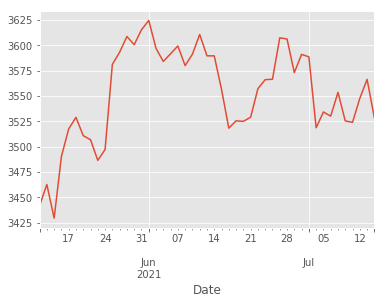

東協


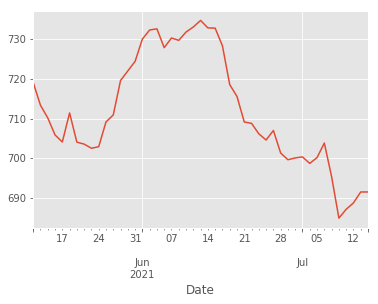

美國


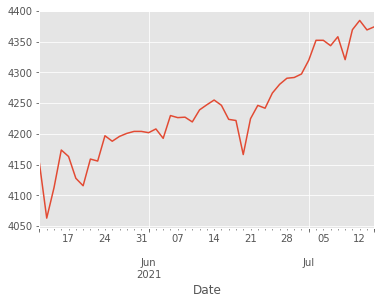

泛太平洋


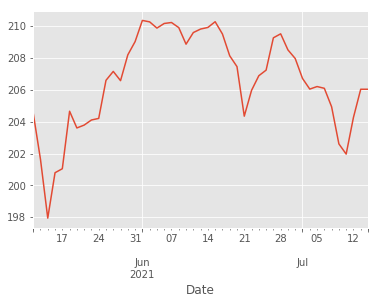

拉丁美洲


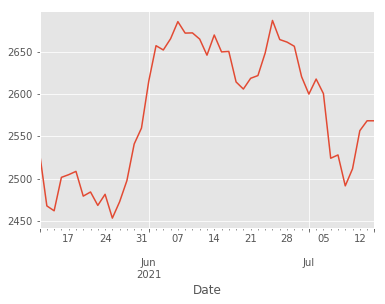

新興亞洲


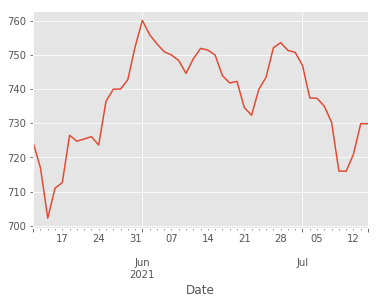

新興歐洲


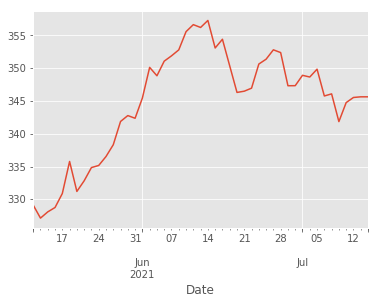

歐洲


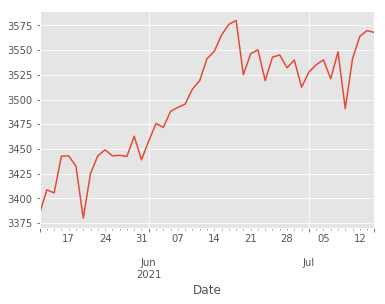

In [91]:

#gbm = lgb.LGBMClassifier(n_estimators=1000, random_state=5, learning_rate=0.05,device='gpu')
#泛太平洋
#新興歐洲
#新興亞洲
#拉丁美洲
L=['中國A',
             '東協',
             '美國',
             '泛太平洋',
             '拉丁美洲',
             '新興亞洲',
             '新興歐洲',
             '歐洲']

for name in L:
    print(name)
    (df_price,indexes)=get_price(subject=name)
    df_price['2021/5/11':].plot()
    plt.show()



